<a href="https://colab.research.google.com/github/miltiadiss/CEID_NE577-5G-Architectures-Technologies-Applications-and-Key-Performance-Indicators/blob/main/Code/XGBoost_Regressor_with_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [148]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from itertools import product
import statsmodels.api as sm

In [30]:
import warnings
warnings.filterwarnings("ignore")

# **XGBOOST REGRESSOR**

**First, we plot the ACF for every feature to determine the amount of lags needed and the interval between them, since the granularity is 1 sec.**

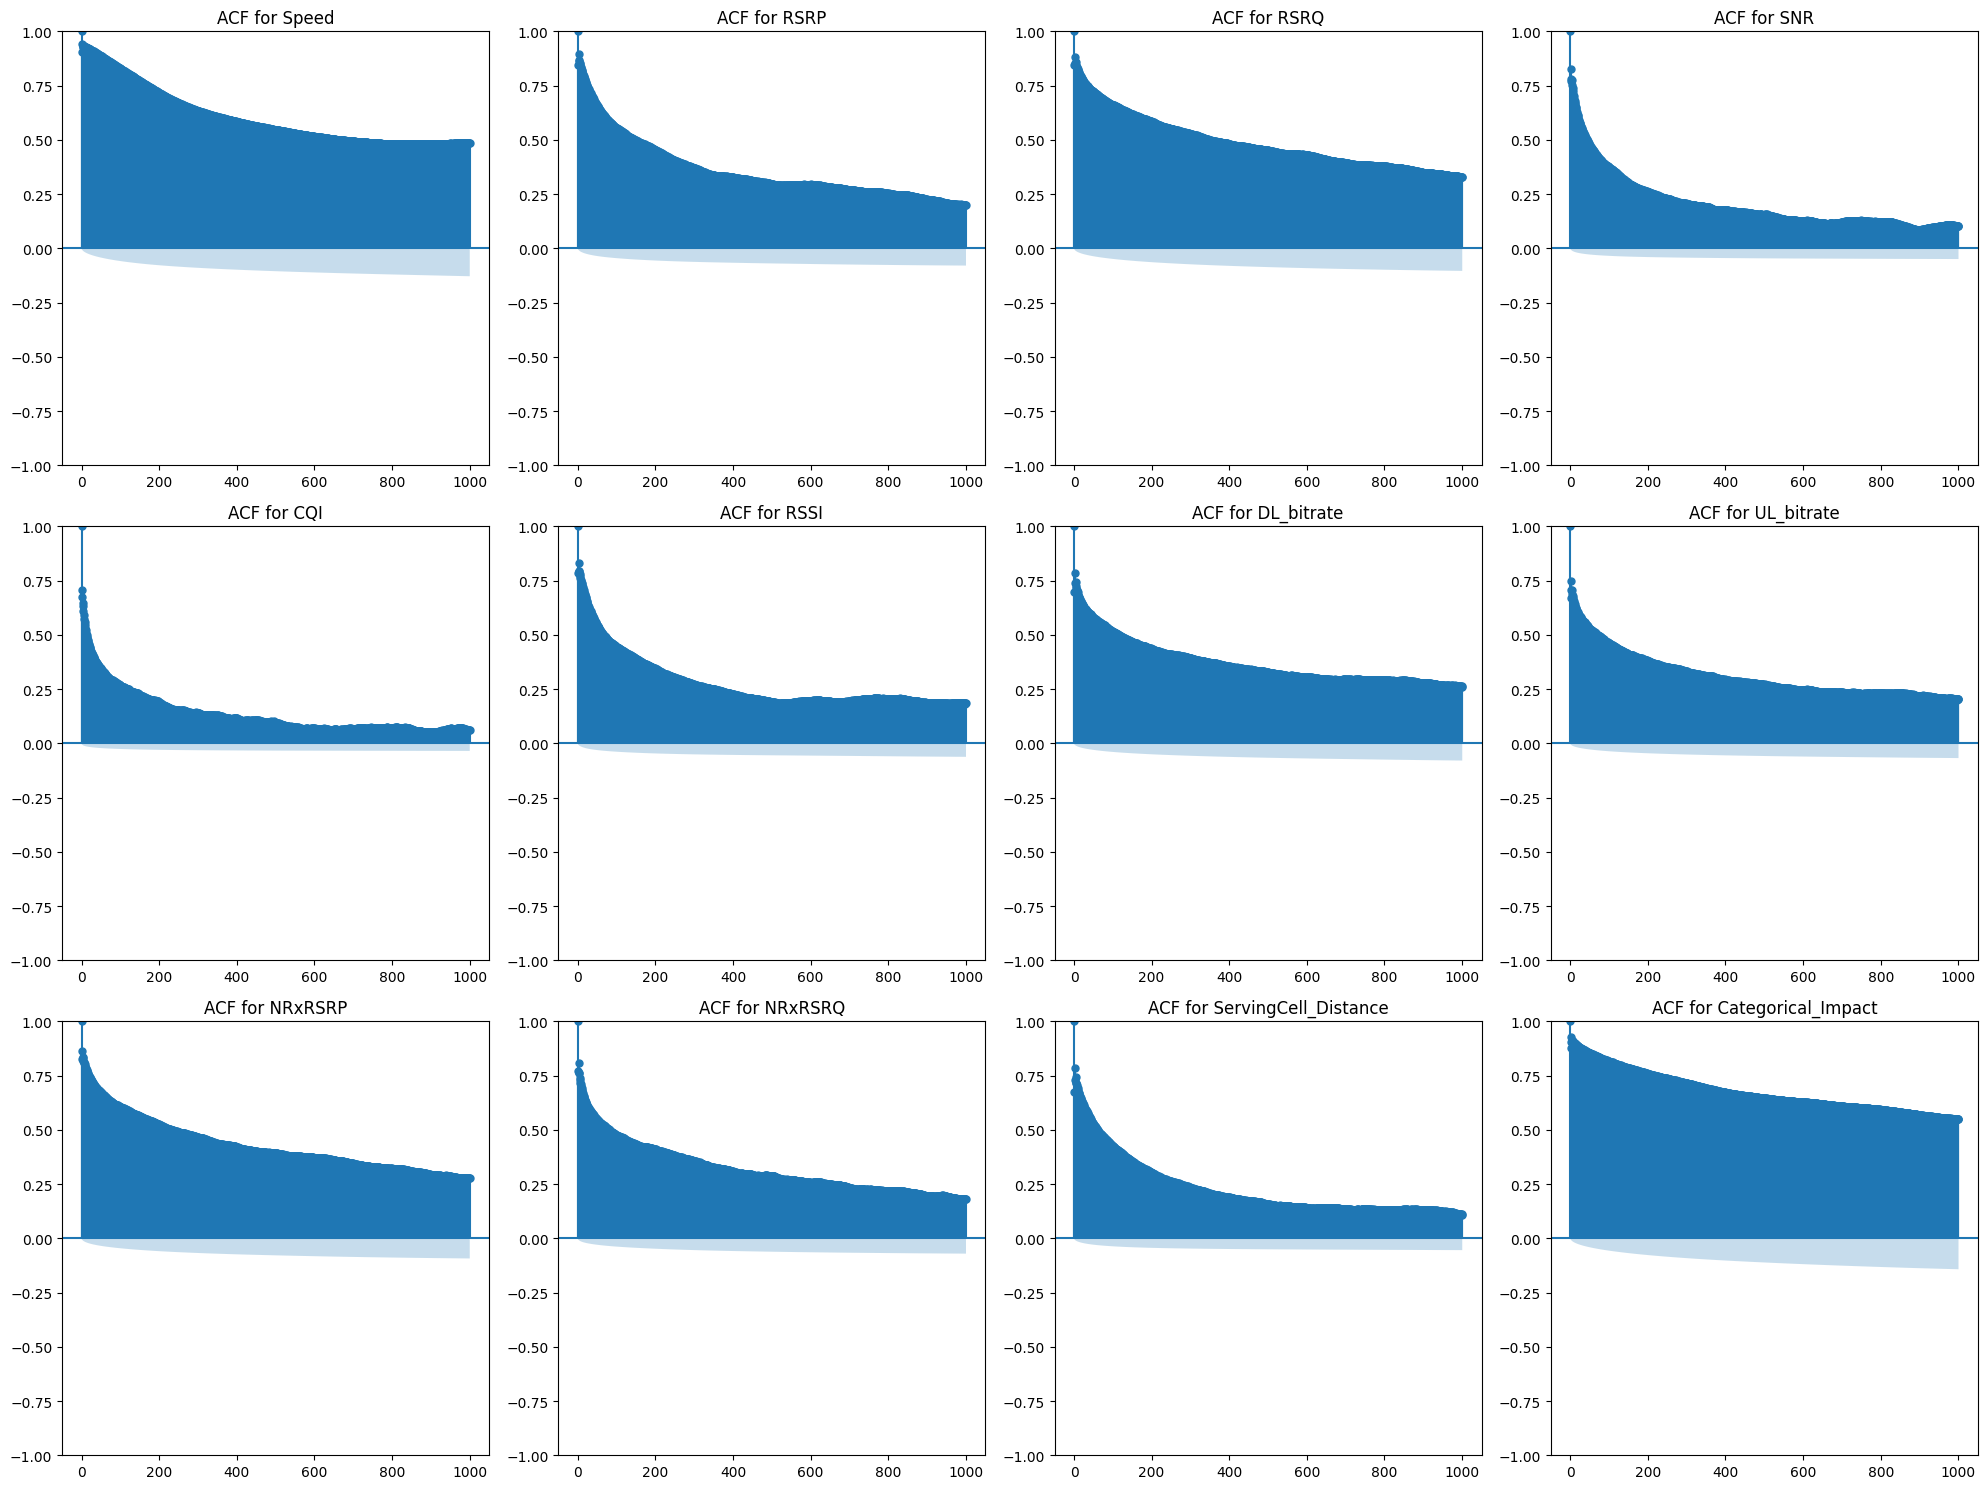

In [163]:
# Φόρτωση του τελικού dataset
df = pd.read_csv("/content/drive/MyDrive/final_dataset.csv")

# Επιλογή όλων των αριθμητικών στηλών (όπως ορίζονται)
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI',
            'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
            'ServingCell_Distance', 'Categorical_Impact']

# Υπολογισμός και σχεδίαση ACF για κάθε αριθμητικό χαρακτηριστικό
rows, cols = 3, 4
num_features = len(features)
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

for i, column in enumerate(features):
    row, col = divmod(i, cols)  # Υπολογισμός θέσης στο grid
    sm.graphics.tsa.plot_acf(df[column].dropna(), lags=1000, alpha=0.05, ax=axes[row, col])
    axes[row, col].set_title(f"ACF for {column}")

plt.tight_layout()
plt.show()

**Then, we apply Grid Search with 5-Cross Validation to determine the best combination of the hyperparameters for the different amount of lagged features. We split the Dataset into the following subsets:**

**Training Set: 70%**

**Validation Set: 15%**

**Test Set: 15%**

**We also apply Z-Score Normalization since the numeric features are measured in different units.**

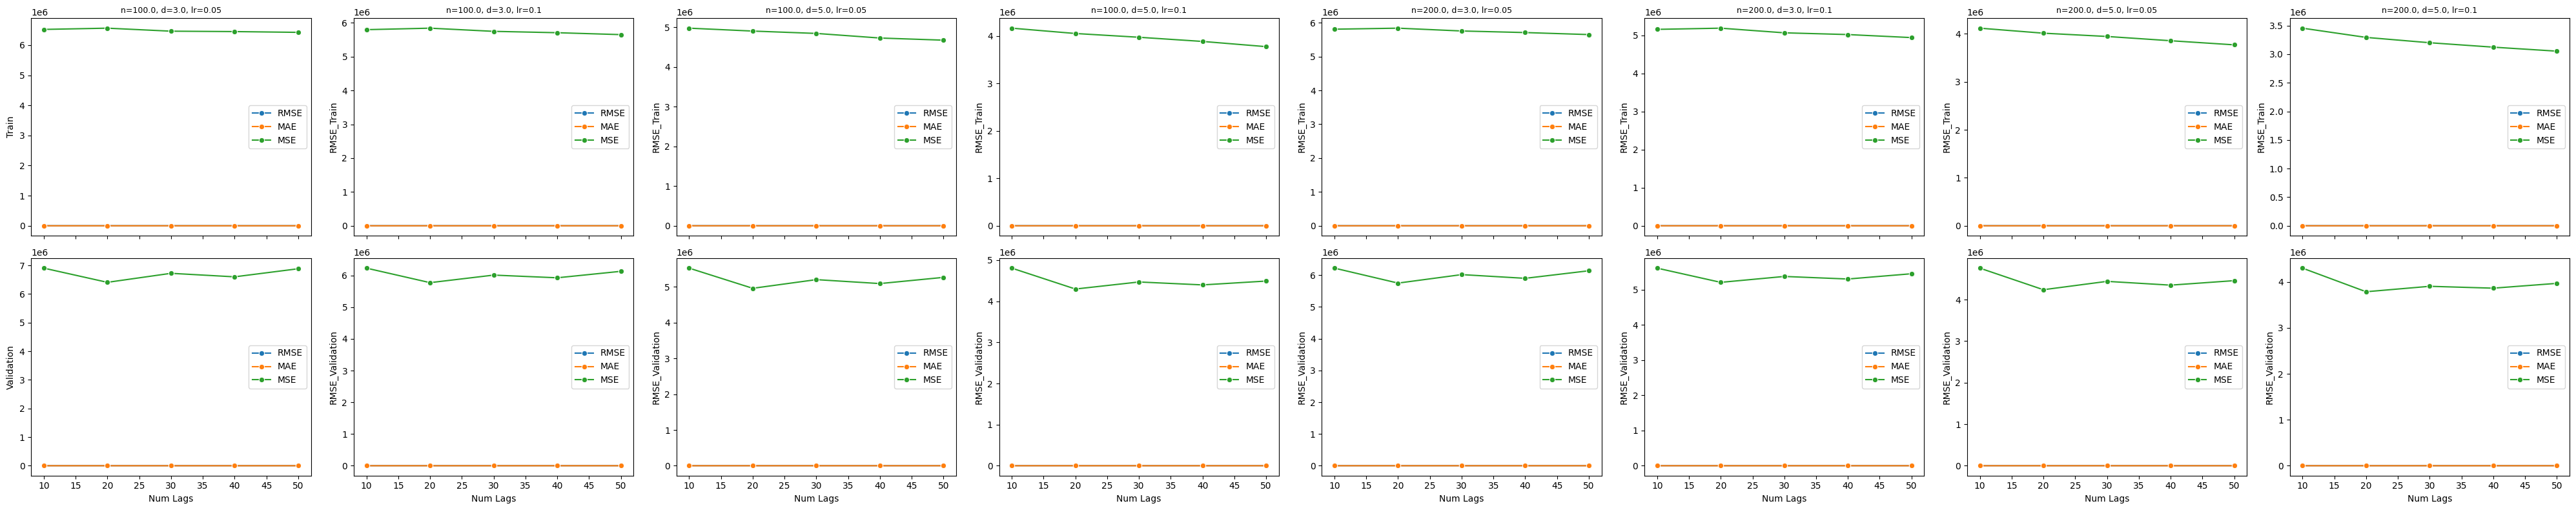

In [37]:
# --- Δημιουργία lagged χαρακτηριστικών
def create_lagged_features(df, features, num_lags, lag_interval=1):
    df = df.copy()
    for feature in features:
        for lag in range(lag_interval, lag_interval * num_lags + 1, lag_interval):
            df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)
    return df.dropna()

# --- Ορισμός χαρακτηριστικών
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI',
            'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
            'ServingCell_Distance', 'Categorical_Impact']

# --- Πίνακας για αποθήκευση αποτελεσμάτων
results_list = []

# --- Παράμετροι
lag_interval = 60  # Λαμβάνουμε δείγμα κάθε 1 λεπτό
num_lags_list = [10, 20, 30, 40, 50] # Πάμε πίσω στο χρόνο από 10 ως 50 λεπτά
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1]
}

# --- Συνδυασμοί υπερπαραμέτρων
param_combinations = list(product(param_grid["n_estimators"],
                                  param_grid["max_depth"],
                                  param_grid["learning_rate"]))

# --- Δημιουργία scalers για κανονικοποίηση
scaler_X = StandardScaler()  # Για τα χαρακτηριστικά
scaler_y = StandardScaler()  # Για τον στόχο

# --- Κύριος βρόχος: num_lags + hyperparameters
for num_lags in num_lags_list:
    df_lagged = create_lagged_features(df, features, num_lags, lag_interval=lag_interval)

    # Διαχωρισμός χαρακτηριστικών και στόχου
    X = df_lagged.drop(columns=["DL_bitrate"])
    y = df_lagged["DL_bitrate"]

    # Κανονικοποίηση των χαρακτηριστικών
    X_scaled = scaler_X.fit_transform(X)

    # Κανονικοποίηση του στόχου (y)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

    # Διαχωρισμός δεδομένων
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    for n_estimators, max_depth, learning_rate in param_combinations:
        # Εκπαίδευση μοντέλου
        model = xgb.XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            objective="reg:squarederror",
            random_state=42
        )
        model.fit(X_train, y_train)

        # Προβλέψεις
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Αποκανονικοποίηση των προβλέψεων (inverse transform)
        y_train_pred_denorm = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
        y_val_pred_denorm = scaler_y.inverse_transform(y_val_pred.reshape(-1, 1)).flatten()

        # Καταγραφή αποτελεσμάτων
        results_list.append({
            "num_lags": num_lags,
            "lag_interval": lag_interval,
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "MSE_Train": mean_squared_error(scaler_y.inverse_transform(y_train.reshape(-1, 1)), y_train_pred_denorm),
            "RMSE_Train": np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_train.reshape(-1, 1)), y_train_pred_denorm)),
            "MAE_Train": mean_absolute_error(scaler_y.inverse_transform(y_train.reshape(-1, 1)), y_train_pred_denorm),
            "MSE_Validation": mean_squared_error(scaler_y.inverse_transform(y_val.reshape(-1, 1)), y_val_pred_denorm),
            "RMSE_Validation": np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_val.reshape(-1, 1)), y_val_pred_denorm)),
            "MAE_Validation": mean_absolute_error(scaler_y.inverse_transform(y_val.reshape(-1, 1)), y_val_pred_denorm)
        })

# --- Δημιουργία DataFrame με τα αποτελέσματα
results_df = pd.DataFrame(results_list)

# --- Εμφάνιση γραφικών (Train και Validation)
metrics = ["RMSE", "MAE", "MSE"]
metric_suffixes = ["Train", "Validation"]

# Συνδυασμοί υπερπαραμέτρων
hyperparam_combinations = results_df[["n_estimators", "max_depth", "learning_rate"]].drop_duplicates()
n_rows = 2
n_cols = 8

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True)

# Εξασφάλιση σωστών διαστάσεων στο grid
axes = axes.reshape(n_rows, n_cols)

for col_idx, (_, combo) in enumerate(hyperparam_combinations.iterrows()):
    mask = (
        (results_df["n_estimators"] == combo["n_estimators"]) &
        (results_df["max_depth"] == combo["max_depth"]) &
        (results_df["learning_rate"] == combo["learning_rate"])
    )
    combo_data = results_df[mask].sort_values("num_lags")

    for row_idx in range(2):  # 0: Train, 1: Validation
        ax = axes[row_idx, col_idx]

        for metric in metrics:
            sns.lineplot(
                data=combo_data,
                x="num_lags",
                y=f"{metric}_{metric_suffixes[row_idx]}",
                marker="o",
                ax=ax,
                label=f"{metric}"
            )

        # Τίτλος σε κάθε στήλη
        if row_idx == 0:
            ax.set_title(f"n={combo['n_estimators']}, d={combo['max_depth']}, lr={combo['learning_rate']}", fontsize=9)

        # Ονομασίες αξόνων
        ax.set_xlabel("Num Lags")
        if col_idx == 0:
            ax.set_ylabel(f"{metric_suffixes[row_idx]}")

plt.tight_layout()
plt.show()

**We train the model using the best combination of lags and hyperparameters and use the test set for the evaluation of the predictions. We also plot the learning curves of the model.**

In [164]:
# --- Δημιουργία lagged χαρακτηριστικών
def create_lagged_features(df, features, num_lags, lag_interval=1):
    df = df.copy()
    for feature in features:
        for lag in range(lag_interval, lag_interval * num_lags + 1, lag_interval):
            df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)
    return df.dropna()

# --- Ορισμός χαρακτηριστικών
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI',
            'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
            'ServingCell_Distance', 'Categorical_Impact']

# --- Δημιουργία lagged χαρακτηριστικών με τα καλύτερα lags
best_num_lags = 10  # Όπως βρήκαμε από τα αποτελέσματα

df_lagged = create_lagged_features(df, features, best_num_lags, lag_interval=60)

# Διαχωρισμός χαρακτηριστικών και στόχου
X = df_lagged.drop(columns=["Timestamp", "DL_bitrate"])
y = df_lagged["DL_bitrate"]

# --- Δημιουργία scalers για κανονικοποίηση
scaler_X = StandardScaler()  # Για τα χαρακτηριστικά
scaler_y = StandardScaler()  # Για τον στόχο

# Κανονικοποίηση των χαρακτηριστικών
X_scaled = scaler_X.fit_transform(X)

# Κανονικοποίηση του στόχου (y)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Διαχωρισμός δεδομένων
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Δημιουργία του τελικού μοντέλου με τις καλύτερες υπερπαραμέτρους
final_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    objective="reg:squarederror",
    random_state=42
)

# Εκπαίδευση του μοντέλου με όλα τα δεδομένα εκπαίδευσης
final_model.fit(X_train, y_train)

# Προβλέψεις στο test set
y_test_pred = final_model.predict(X_test)

# Αποκανονικοποίηση των προβλέψεων
y_test_pred_denorm = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

# Δημιουργία μιας νέας στήλης με τις προβλεπόμενες τιμές στο αρχικό df
df.loc[len(df) - len(y_test_pred_denorm):, 'Predicted_DL_bitrate'] = y_test_pred_denorm

# Υπολογισμός μετρικών απόδοσης στο test set
test_rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_test_pred_denorm))
test_mae = mean_absolute_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_test_pred_denorm)
test_mse = mean_squared_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_test_pred_denorm)

print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")

Test RMSE: 2046.4749203132537
Test MAE: 1130.2818172652921
Test MSE: 4188059.599471138


[0]	train-rmse:0.90919	train-mae:0.71671	eval-rmse:0.90190	eval-mae:0.70883
[10]	train-rmse:0.39654	train-mae:0.29658	eval-rmse:0.39407	eval-mae:0.29443
[20]	train-rmse:0.25701	train-mae:0.16633	eval-rmse:0.26375	eval-mae:0.16787
[30]	train-rmse:0.22090	train-mae:0.12841	eval-rmse:0.23573	eval-mae:0.13342
[40]	train-rmse:0.20603	train-mae:0.11710	eval-rmse:0.22593	eval-mae:0.12397
[50]	train-rmse:0.19715	train-mae:0.11238	eval-rmse:0.22155	eval-mae:0.12085
[60]	train-rmse:0.19056	train-mae:0.10954	eval-rmse:0.21848	eval-mae:0.11925
[70]	train-rmse:0.18587	train-mae:0.10758	eval-rmse:0.21689	eval-mae:0.11884
[80]	train-rmse:0.18103	train-mae:0.10551	eval-rmse:0.21586	eval-mae:0.11851
[90]	train-rmse:0.17694	train-mae:0.10378	eval-rmse:0.21503	eval-mae:0.11829
[100]	train-rmse:0.17227	train-mae:0.10178	eval-rmse:0.21332	eval-mae:0.11752
[110]	train-rmse:0.16855	train-mae:0.10011	eval-rmse:0.21246	eval-mae:0.11713
[120]	train-rmse:0.16566	train-mae:0.09864	eval-rmse:0.21192	eval-mae:0.116

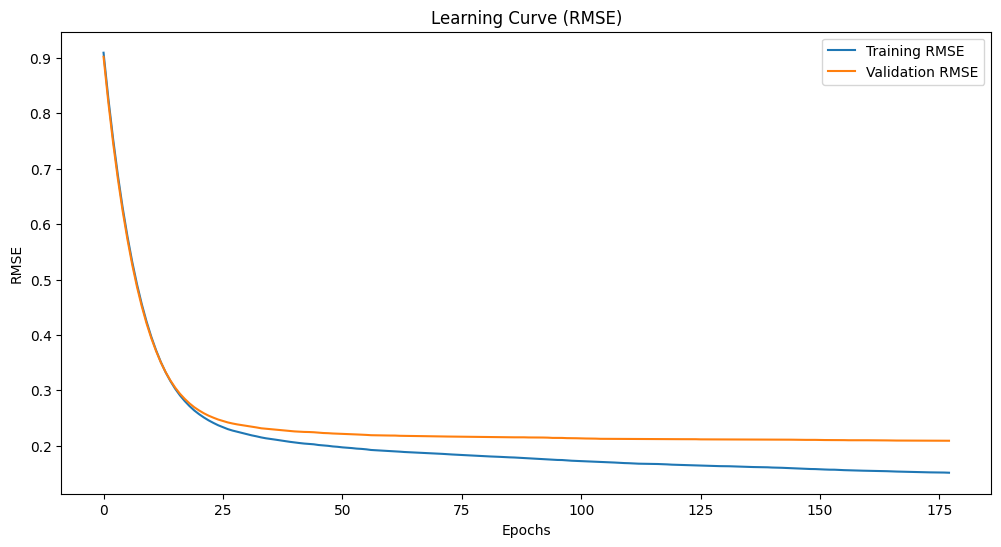

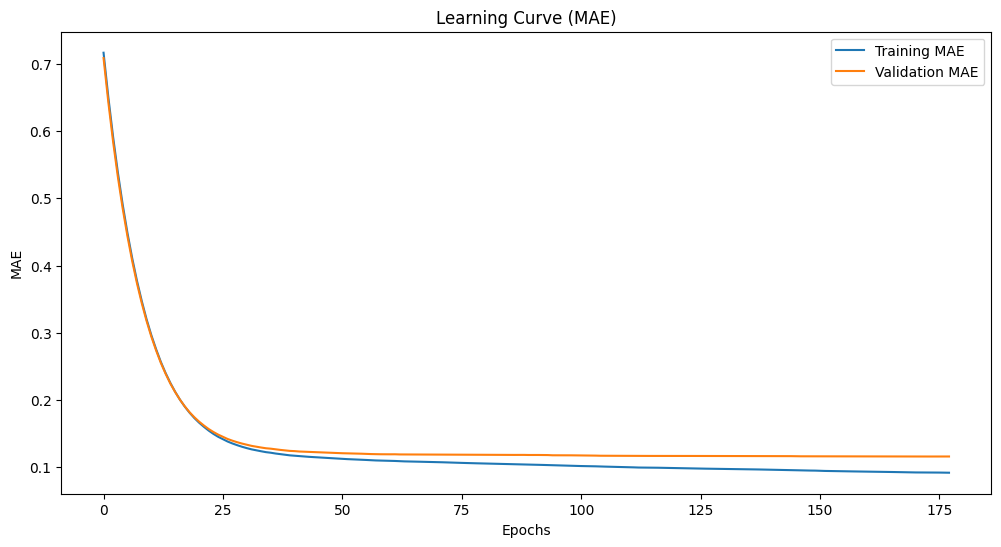

Test RMSE: 2240.3343979077245
Test MAE: 1229.7962094233492
Test MSE: 5019098.214448567


In [170]:
# --- Δημιουργία lagged χαρακτηριστικών
def create_lagged_features(df, features, num_lags, lag_interval=1):
    df = df.copy()
    for feature in features:
        for lag in range(lag_interval, lag_interval * num_lags + 1, lag_interval):
            df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)
    return df.dropna()

# --- Ορισμός χαρακτηριστικών
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI',
            'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
            'ServingCell_Distance', 'Categorical_Impact']

# --- Δημιουργία lagged χαρακτηριστικών με τα καλύτερα lags
best_num_lags = 10  # Όπως βρήκαμε από τα αποτελέσματα

df_lagged = create_lagged_features(df, features, best_num_lags, lag_interval=60)

# Διαχωρισμός χαρακτηριστικών και στόχου
X = df_lagged.drop(columns=["Timestamp", "DL_bitrate"])
y = df_lagged["DL_bitrate"]

# --- Δημιουργία scalers για κανονικοποίηση
scaler_X = StandardScaler()  # Για τα χαρακτηριστικά
scaler_y = StandardScaler()  # Για τον στόχο

# Κανονικοποίηση των χαρακτηριστικών
X_scaled = scaler_X.fit_transform(X)

# Κανονικοποίηση του στόχου (y)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Διαχωρισμός δεδομένων σε train, validation και test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Δημιουργία DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Ορισμός βέλτιστων υπερπαραμέτρων
params = {
    'objective': 'reg:squarederror',  # Προβλεπτικό σφάλμα
    'max_depth': 5,                   # Βάθος του δέντρου
    'learning_rate': 0.1,             # Ρυθμός εκμάθησης
    'n_estimators': 200,              # Αριθμός δέντρων
    'eval_metric': ['rmse', 'mae']    # Προσθήκη MAE ως μετρικής
}

# Ορισμός evals (train και validation set)
evals = [(dtrain, 'train'), (dval, 'eval')]

# Εκπαίδευση του μοντέλου
num_round = 200  # Αριθμός εποχών (iterations)
history = dict()

bst = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=10, verbose_eval=10, evals_result=history)

# Λήψη αποτελεσμάτων εκπαίδευσης για τις μετρικές
results = history

# Σχεδίαση Learning Curves για RMSE
epochs = len(results['train']['rmse'])  # Αριθμός εποχών
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), results['train']['rmse'], label="Training RMSE")
plt.plot(range(epochs), results['eval']['rmse'], label="Validation RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Learning Curve (RMSE)")
plt.legend()
plt.show()

# Σχεδίαση Learning Curves για MAE
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), results['train']['mae'], label="Training MAE")
plt.plot(range(epochs), results['eval']['mae'], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Learning Curve (MAE)")
plt.legend()
plt.show()

# Προβλέψεις στο test set
y_test_pred = bst.predict(dtest)

# Αποκανονικοποίηση των προβλέψεων
y_test_pred_denorm = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

# Δημιουργία μιας νέας στήλης με τις προβλεπόμενες τιμές στο αρχικό df
df.loc[len(df) - len(y_test_pred_denorm):, 'Predicted_DL_bitrate'] = y_test_pred_denorm

# Υπολογισμός μετρικών απόδοσης στο test set
test_rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_test_pred_denorm))
test_mae = mean_absolute_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_test_pred_denorm)
test_mse = mean_squared_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_test_pred_denorm)

print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")

**We calculate for better understanding the percentages of the error metrics to see how far the predictions are from the average actual DL_bitrate of the test data.**

In [171]:
# Υπολογισμός της μέσης πραγματικής τιμής του test set
mean_actual_value = y.mean()

# Αξιολόγηση των μετρικών σφάλματος ως προς τη μέση πραγματική τιμή
print(f"Average Actual DL bitrate of tested samples: {mean_actual_value:.2f} Kbps")
print(f"Percentage of MAE: {(test_mae / mean_actual_value) * 100:.2f}%")
print(f"Percentage of RMSE: {(test_rmse / mean_actual_value) * 100:.2f}%")

Average Actual DL bitrate of tested samples: 9133.01 Kbps
Percentage of MAE: 13.47%
Percentage of RMSE: 24.53%


**Finally, after the evaluation of the model we plot the actual and the predicted timeseries to visualize the results.**

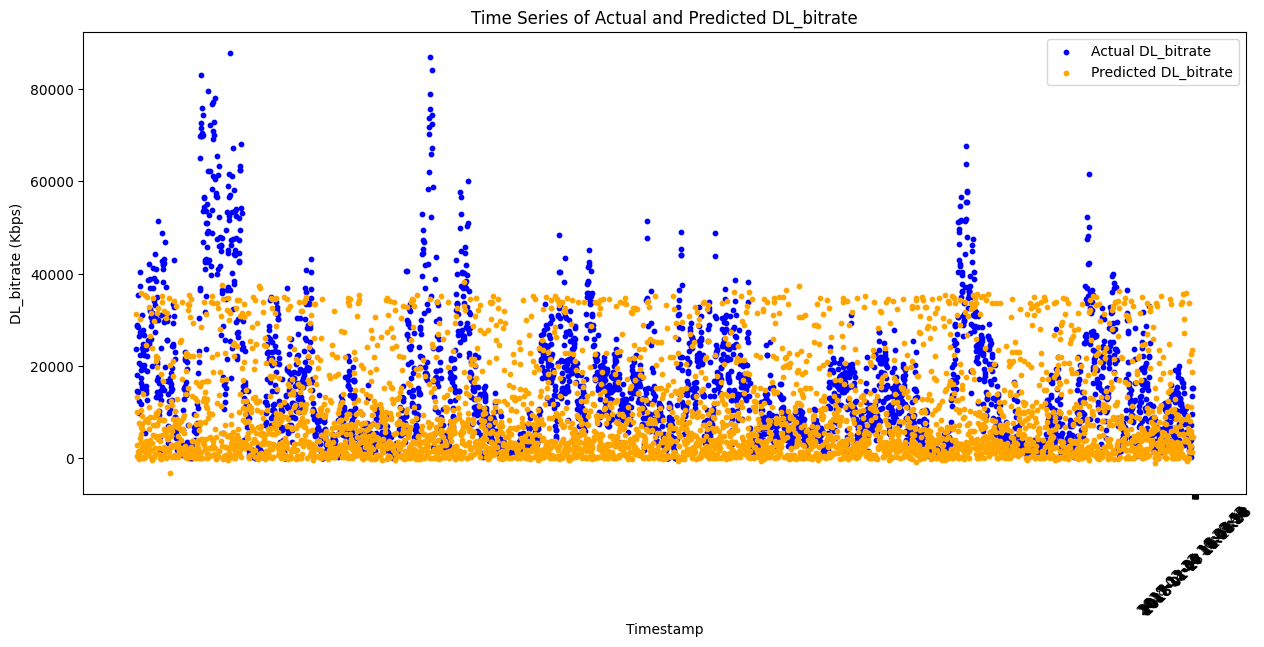

In [172]:
# --- Σχεδίαση Χρονοσειράς για τις πραγματικές και τις προβλεπόμενες τιμές
initial_df = pd.read_csv("/content/drive/MyDrive/combined_dataset.csv")
initial_df['Timestamp'] = df['Timestamp'].astype(str)

plt.figure(figsize=(15, 6))

# Σχεδιάζουμε την πραγματική χρονοσειρά για τα δεδομένα του test set
plt.scatter(initial_df['Timestamp'].iloc[-len(y_test_pred_denorm):], initial_df['DL_bitrate'].iloc[-len(y_test_pred_denorm):], color='blue', label="Actual DL_bitrate", s=10)

# Σχεδιάζουμε την προβλεπόμενη χρονοσειρά για τα δεδομένα του test set
plt.scatter(df['Timestamp'].iloc[-len(y_test_pred_denorm):], df['Predicted_DL_bitrate'].iloc[-len(y_test_pred_denorm):], color='orange', label="Predicted DL_bitrate", s=10)

# Προσθήκη ετικετών στον άξονα x και y
plt.xlabel("Timestamp")
plt.ylabel("DL_bitrate (Kbps)")

# Προσθήκη τίτλου στο γράφημα
plt.title("Time Series of Actual and Predicted DL_bitrate")

# Μείωση των ticks στον άξονα x για καλύτερη αναγνωσιμότητα
plt.xticks(ticks=df['Timestamp'][::max(1, len(df) // 10)].iloc[-len(y_test_pred_denorm):], rotation=45)

# Προσθήκη υπομνήματος (legend)
plt.legend()

# Εμφάνιση του γραφήματος
plt.show()